# Experiment notebook
Andrew Nguyen, 09/06/2019

Summary: <br>
Experiment notebook, try different models, features, etc.

In [6]:
# Summary:
# 2 utterance -> linearsvm

In [7]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Adding project root and custom functions
from os import listdir, getcwd
from os.path import isfile, join
import sys
from pathlib import Path

def find_root_dir():
    # find config.py
    path = Path(getcwd()).parent
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    while "config.py" not in onlyfiles:
        path = path.parent
        onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
        
    return path

ROOT_DIR = str(find_root_dir())
sys.path.append(ROOT_DIR)

from config import get_project_root
# custom functs
from src.features import build_features
from src.visualization.visualize import plot_confusion_matrix

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy

import random
from collections import Counter

from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import Binarizer
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.utils.multiclass import unique_labels

## Prepare data

In [12]:
ROOT_PATH = get_project_root()
TRAIN_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.train.json"
DEV_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.dev.json"
TEST_PATH = ROOT_PATH / "data/raw/EmotionX2018/emotionpush.test.json"

df_train = build_features.to_df(TRAIN_PATH)
df_dev = build_features.to_df(DEV_PATH)
df_test = build_features.to_df(TEST_PATH)

In [13]:
df_train["split"] = "train"
df_dev["split"] = "dev"
df_test["split"] = "test"

In [14]:
# concat df
df = pd.concat([df_train, df_dev, df_test], ignore_index=True)
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split
0,4001000,0,NaN,neutral,neutral,NaN,Sorry to bother you but do you have the 270 te...,What's it called,train
1,4000010,0,neutral,neutral,neutral,Sorry to bother you but do you have the 270 te...,What's it called,Digital design and principles I think,train
2,5000000,0,neutral,neutral,neutral,What's it called,Digital design and principles I think,I don't think so?,train
3,3000020,0,neutral,neutral,neutral,Digital design and principles I think,I don't think so?,I could be wrong,train
4,5000000,0,neutral,neutral,neutral,I don't think so?,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,train
5,3020000,0,neutral,neutral,neutral,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,train
6,5000000,0,neutral,neutral,neutral,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,*book,train
7,5000000,0,neutral,neutral,neutral,You don't need the boom,*book,"If I do have it, I never used it",train
8,4000010,0,neutral,neutral,non-neutral,*book,"If I do have it, I never used it",But you had a good professor,train
9,2110100,0,neutral,non-neutral,neutral,"If I do have it, I never used it",But you had a good professor,I mean you can use the notes,train


In [16]:
# load augmented trans
AUG_PATH = ROOT_PATH / "data/raw/EmotionPush/emotionpush.augmented.json"
df_aug = build_features.to_df(AUG_PATH)
df = df.merge(df_aug, how='inner', on=["utterance2", "annotation", "emotion2", "utterance1", "emotion1", "utterance3", "emotion3"])

In [17]:
# simplify emotion labels
df = df[df.emotion2.isin(["neutral", "joy", "sadness", "anger"])]

In [18]:
df = df.reset_index(drop=True)

In [24]:
cols = ["emotion1", "emotion2", "emotion3", "utterance1", "utterance2", "utterance3", "split", "utterance1_de", "utterance1_fr", "utterance1_it", "utterance2_de", "utterance2_fr", "utterance2_it", "utterance3_de", "utterance3_fr", "utterance3_it"]

In [25]:
df = df[cols]

In [26]:
df = df

,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split,utterance1_de,utterance1_fr,utterance1_it,utterance2_de,utterance2_fr,utterance2_it,utterance3_de,utterance3_fr,utterance3_it
0,NaN,neutral,neutral,NaN,Sorry to bother you but do you have the 270 te...,What's it called,train,NaN,NaN,NaN,"Excuse the error, but do you have the textbook?","Sorry to bother you, but do you have the 270 m...","Sorry if I'm bothering you, but do you have a ...",What do you call it,How do you call this,What's your name
1,neutral,neutral,neutral,Sorry to bother you but do you have the 270 te...,What's it called,Digital design and principles I think,train,"Excuse the error, but do you have the textbook?","Sorry to bother you, but do you have the 270 m...","Sorry if I'm bothering you, but do you have a ...",What do you call it,How do you call this,What's your name,"Digital design and principles, I think",Digital design and principles I think,Digital design and principles that I think
2,neutral,neutral,neutral,What's it called,Digital design and principles I think,I don't think so?,train,What do you call it,How do you call this,What's your name,"Digital design and principles, I think",Digital design and principles I think,Digital design and principles that I think,I do not think so?,I do not think so?,I do not think so?
3,neutral,neutral,neutral,Digital design and principles I think,I don't think so?,I could be wrong,train,"Digital design and principles, I think",Digital design and principles I think,Digital design and principles that I think,I do not think so?,I do not think so?,I do not think so?,I could be wrong,I could be wrong,I might be wrong
4,neutral,neutral,neutral,I don't think so?,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,train,I do not think so?,I do not think so?,I do not think so?,I could be wrong,I could be wrong,I might be wrong,OK that's fine. I'm just trying not to pay for...,Okay that's good. I'm just trying to avoid pay...,OK it's good. I'm just trying to avoid paying ...
5,neutral,neutral,neutral,I could be wrong,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,train,I could be wrong,I could be wrong,I might be wrong,OK that's fine. I'm just trying not to pay for...,Okay that's good. I'm just trying to avoid pay...,OK it's good. I'm just trying to avoid paying ...,You do not need the boom,You do not need the boom,You do not need the boom
6,neutral,neutral,neutral,Ok that's fine. I'm just trying hard to avoid ...,You don't need the boom,*book,train,OK that's fine. I'm just trying not to pay for...,Okay that's good. I'm just trying to avoid pay...,OK it's good. I'm just trying to avoid paying ...,You do not need the boom,You do not need the boom,You do not need the boom,*Book,*book,*book
7,neutral,neutral,neutral,You don't need the boom,*book,"If I do have it, I never used it",train,You do not need the boom,You do not need the boom,You do not need the boom,*Book,*book,*book,"When I got it, I never used it","If I have it, I've never used it","If I have it, I've never used it"
8,neutral,neutral,non-neutral,*book,"If I do have it, I never used it",But you had a good professor,train,*Book,*book,*book,"When I got it, I never used it","If I have it, I've never used it","If I have it, I've never used it",But you had a good professor,But you had a good teacher,But you had a good professor
9,non-neutral,neutral,neutral,But you had a good professor,I mean you can use the notes,It tells you everything you need to know,train,But you had a good professor,But you had a good teacher,But you had a good professor,"I mean, you can use the notes",I mean you can use the notes,"I mean, you can use the notes",It tells you everything you need to know,He tells you everything you need to know,It tells you everything you need to know


## Preprocess

In [28]:
# make nan utterances -> empty strings
df.utterance1 = df.utterance1.fillna("")
df.utterance3 = df.utterance3.fillna("")
df.utterance1_de = df.utterance1_de.fillna("")
df.utterance1_fr = df.utterance1_fr.fillna("")
df.utterance1_it = df.utterance1_it.fillna("")
df.utterance3_de = df.utterance3_de.fillna("")
df.utterance3_fr = df.utterance3_fr.fillna("")
df.utterance3_it = df.utterance3_it.fillna("")

In [31]:
# explode out de, fr, it translations
newd = []
for i in range(len(df)):
    d={}
    d_de={}
    d_fr={}
    d_it={}
    row = df.iloc[i]
    d = {
        "emotion1": row["emotion1"],
        "emotion2": row["emotion2"],
        "emotion3": row["emotion3"],
        "utterance1": row["utterance1"],
        "utterance2": row["utterance2"],
        "utterance3": row["utterance3"],
        "split": row["split"]
    }
    d_de = {
        "emotion1": row["emotion1"],
        "emotion2": row["emotion2"],
        "emotion3": row["emotion3"],
        "utterance1": row["utterance1_de"],
        "utterance2": row["utterance2_de"],
        "utterance3": row["utterance3_de"],
        "split": row["split"]
    }    
    d_fr = {
        "emotion1": row["emotion1"],
        "emotion2": row["emotion2"],
        "emotion3": row["emotion3"],
        "utterance1": row["utterance1_fr"],
        "utterance2": row["utterance2_fr"],
        "utterance3": row["utterance3_fr"],
        "split": row["split"]
    }     
    d_it = {
        "emotion1": row["emotion1"],
        "emotion2": row["emotion2"],
        "emotion3": row["emotion3"],
        "utterance1": row["utterance1_it"],
        "utterance2": row["utterance2_it"],
        "utterance3": row["utterance3_it"],
        "split": row["split"]
    } 
    newd.append(d)
    newd.append(d_de)
    newd.append(d_fr)
    newd.append(d_it)

In [38]:
df = pd.DataFrame(newd)

In [40]:
# preappend utterance 1 + utterance 2 with number
tokenizer = TweetTokenizer(reduce_len=True, preserve_case=False)

def preappend(sent, num):
    words = tokenizer.tokenize(sent)
    
    # remove stop words
    stopWords = set(stopwords.words('english'))
    words = [ w for w in words if w not in stopWords]
    
    words = [ num + w for w in words]
    return words

df.utterance1 = df.utterance1.apply(lambda x: preappend(x, "1_"))
df.utterance2 = df.utterance2.apply(lambda x: preappend(x, "2_"))
df.utterance3 = df.utterance3.apply(lambda x: preappend(x, "3_"))

In [41]:
# append utt1 and utt2 arrays together
temp = df[["utterance1", "utterance2"]].values.tolist()
temp = [ t[0] + t[1] for t in temp]
df["utterance12"] = temp

## TFIDF 

In [13]:
df

,annotation,convoId,emotion1,emotion2,emotion3,utterance1,utterance2,utterance3,split,utterance123
0,4001000,0,NaN,neutral,neutral,[],"[2_sorry, 2_bother, 2_270, 2_textbook, 2_?]","[3_what's, 3_called]",train,"[2_sorry, 2_bother, 2_270, 2_textbook, 2_?]"
1,4000010,0,neutral,neutral,neutral,"[1_sorry, 1_bother, 1_270, 1_textbook, 1_?]","[2_what's, 2_called]","[3_digital, 3_design, 3_principles, 3_think]",train,"[1_sorry, 1_bother, 1_270, 1_textbook, 1_?, 2_..."
2,5000000,0,neutral,neutral,neutral,"[1_what's, 1_called]","[2_digital, 2_design, 2_principles, 2_think]","[3_think, 3_?]",train,"[1_what's, 1_called, 2_digital, 2_design, 2_pr..."
3,3000020,0,neutral,neutral,neutral,"[1_digital, 1_design, 1_principles, 1_think]","[2_think, 2_?]","[3_could, 3_wrong]",train,"[1_digital, 1_design, 1_principles, 1_think, 2..."
4,5000000,0,neutral,neutral,neutral,"[1_think, 1_?]","[2_could, 2_wrong]","[3_ok, 3_that's, 3_fine, 3_., 3_i'm, 3_trying,...",train,"[1_think, 1_?, 2_could, 2_wrong]"
5,3020000,0,neutral,neutral,neutral,"[1_could, 1_wrong]","[2_ok, 2_that's, 2_fine, 2_., 2_i'm, 2_trying,...","[3_need, 3_boom]",train,"[1_could, 1_wrong, 2_ok, 2_that's, 2_fine, 2_...."
6,5000000,0,neutral,neutral,neutral,"[1_ok, 1_that's, 1_fine, 1_., 1_i'm, 1_trying,...","[2_need, 2_boom]","[3_*, 3_book]",train,"[1_ok, 1_that's, 1_fine, 1_., 1_i'm, 1_trying,..."
7,5000000,0,neutral,neutral,neutral,"[1_need, 1_boom]","[2_*, 2_book]","[3_,, 3_never, 3_used]",train,"[1_need, 1_boom, 2_*, 2_book]"
8,4000010,0,neutral,neutral,non-neutral,"[1_*, 1_book]","[2_,, 2_never, 2_used]","[3_good, 3_professor]",train,"[1_*, 1_book, 2_,, 2_never, 2_used]"
9,5000000,0,non-neutral,neutral,neutral,"[1_good, 1_professor]","[2_mean, 2_use, 2_notes]","[3_tells, 3_everything, 3_need, 3_know]",train,"[1_good, 1_professor, 2_mean, 2_use, 2_notes]"


In [42]:
# get vocab
ll = df.utterance12.values.tolist()

shared_vocab = set()
for l in ll:
    shared_vocab.update(l)

In [43]:
counts_df = pd.DataFrame(columns=list(shared_vocab), index = ["anger", "joy", "neutral", "sadness"])
counts_df = counts_df.fillna(0)

## Counting the number of occurances of each token in the corpus of each class
for i, tokens in enumerate(df['utterance12']):
    for word in tokens:
        if word in shared_vocab:
            labl =  df['emotion2'][i]
            counts_df[word][labl]+=1

In [44]:
tfidf = TfidfTransformer()

X_tfidf = tfidf.fit_transform(counts_df.values).toarray()

In [45]:
word_score = []
word_emote = []
for x in zip(*X_tfidf):
    y = [('angry', x[0]), ('joy', x[1]), ('neutral', x[2]), ('sadness', x[3])]
    y = sorted(y, key=lambda x: x[1])
    word_score.append(y[3][1] - y[2][1])
    word_emote.append(y[3][0])

In [46]:
gg = list(zip(shared_vocab, word_score, word_emote))

In [47]:
ggg = sorted(gg, key=lambda x:x[1], reverse=True)
ggg

[('2_:(', 0.40380227885977876, 'sadness'),
 ('2_lol', 0.34101725703512953, 'joy'),
 ('2_sorry', 0.30491574536361243, 'sadness'),
 ('2_!', 0.23469961786088034, 'joy'),
 ('2_haha', 0.23401578482546326, 'joy'),
 ('2_fuck', 0.22099524153647077, 'angry'),
 ('2_?', 0.20658354806005866, 'neutral'),
 ('1_?', 0.15614599343360283, 'neutral'),
 ('2_.', 0.12769210334505587, 'angry'),
 ('2_miss', 0.11913516139738257, 'sadness'),
 ('1_!', 0.11717648601326239, 'joy'),
 ('2_damn', 0.108292423331884, 'angry'),
 ('2_love', 0.10589154943454306, 'joy'),
 ('2_:)', 0.10562492225762615, 'joy'),
 ('1_/', 0.10212760789608932, 'angry'),
 ('2_poor', 0.10131620555460895, 'sadness'),
 ("2_i'm", 0.09701774709760996, 'sadness'),
 ('2_hate', 0.09108997700507201, 'angry'),
 ('2_aw', 0.0828966326469252, 'sadness'),
 ('2_fucking', 0.07936081622446454, 'angry'),
 ('2_hahaha', 0.07929548165099788, 'joy'),
 ('2_thank', 0.07819575956207099, 'joy'),
 ('2_sad', 0.07688092831231129, 'sadness'),
 ('2_bad', 0.07460534793966933, 

In [48]:
vocab = [ w[0] for w in ggg]

## Feature transform (onehot)

In [49]:
X = df.utterance12

def do_nothing(tokens):
    return tokens

#  [1000, 2500, 5000, 10000]:
curvocab = vocab[0:5000]

freq = CountVectorizer(tokenizer=do_nothing, vocabulary=curvocab, preprocessor=None, lowercase=False)
X = freq.fit_transform(X)

onehot = Binarizer()
X = onehot.fit_transform(X.toarray())

In [50]:
len(freq.vocabulary_)

5000

##  Train test split

In [23]:
# # X as is from above
# y = df.emotion2

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
# # X as is from above
y = df.emotion2
split = df.split

In [52]:
trainIdx = split[split.isin(["train", "dev"])].index.tolist()
testIdx = split[split == "test"].index.tolist()

X_train = [X[i] for i in trainIdx]
X_test = [X[i] for i in testIdx]
y_train = [y[i] for i in trainIdx]
y_test = [y[i] for i in testIdx]

## Fit Model 0

In [53]:
clf = LinearSVC(random_state=0)

In [54]:
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [55]:
# predict
y_pred = clf.predict(X_test)

## Eval predictions

Confusion matrix, without normalization
[[   8   29  110    1]
 [   6 1132  678   20]
 [   6  351 7206  101]
 [  12   22  172  142]]


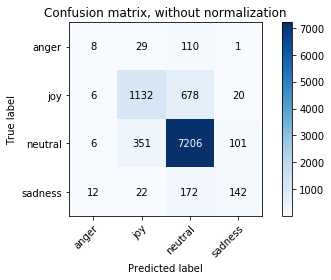

In [56]:
np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')



plt.show()

Normalized confusion matrix
[[5.41e-02 1.96e-01 7.43e-01 6.76e-03]
 [3.27e-03 6.17e-01 3.69e-01 1.09e-02]
 [7.83e-04 4.58e-02 9.40e-01 1.32e-02]
 [3.45e-02 6.32e-02 4.94e-01 4.08e-01]]


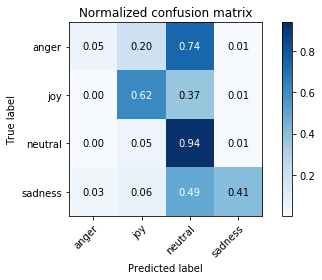

In [57]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Normalized confusion matrix')

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.25      0.05      0.09       148
         joy       0.74      0.62      0.67      1836
     neutral       0.88      0.94      0.91      7664
     sadness       0.54      0.41      0.46       348

   micro avg       0.85      0.85      0.85      9996
   macro avg       0.60      0.50      0.53      9996
weighted avg       0.83      0.85      0.84      9996



## Micro F1

In [59]:
print("{:.4f}".format(f1_score(y_test, y_pred, average='micro')))

0.8491
